In [2]:
from os.path import join
import pandas as pd
import networkx as nx
import numpy as np
from math import copysign
import graph_tool.all as gt
import nx2gt
import settings
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

measure = 'likelihood'
metric = 'spearman'

In [3]:
wd = '/Users/alison/Documents/FishEtho'
criteria = [*settings.criteria_dict.values()]
C = len(criteria)

corrs = pd.read_csv(join(wd, 'data', metric, measure, 'total_corrs.csv'), index_col=[0])
present = pd.read_csv(join(wd, 'data', metric, measure, 'percentage_present.csv'), index_col=[0])
corrs.columns = criteria
corrs.index = criteria
present.columns = criteria
present.index = criteria

In [18]:
# populate weights dictionary for each pair of criteria
ew = 20  # edge width (for visuals)

weights = {}
for i in range(C):
    for j in range(C):
        if i < j:
            corr = corrs.iloc[i, j]
            perc_present = present.iloc[i, j]
            if not np.isnan(corr):
                weights[(i, j)] = corr * perc_present
            
            
# define edge weights using a dict
minw = -2
edges = {(tup[0], tup[1], weight, abs(weight), 0.5 * (copysign(1, weight) + 1), weight - minw) for tup, weight in weights.items()}
nodes = [x for x in range(len(corrs))]
index_dict = {key: value for key, value in zip(range(C), criteria)}
color_dict = {0: '#58333E', 1: '#393E69', 2: '#406D71', 3: '#9C8A5A'}

In [19]:
# using networkx for Louvain algorithm
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([(edge[0], edge[1], edge[2]) for edge in edges])

A = nx.adjacency_matrix(G).todense()
np.savetxt(join(wd, 'data', metric, measure, 'adjacency_weighted.csv'), A, delimiter=",")

# ill-defined for negative edges
communities = louvain_communities(G, weight='weight', seed=0)

community_dict = {}
for i, community in enumerate(communities):
    community_dict[i] = community
community_dict = {value: key for key, values in community_dict.items() for value in values}

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_71414/1444128683.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [20]:
edgewidth = 1

# create a graph_tool Graph
g = gt.Graph(directed=False)
weight = g.new_ep("double")
weight_viz = g.new_ep("double")
weight_shift = g.new_ep("double")
sign = g.new_ep("double")

# add edge attributes
g.add_edge_list(edges, eprops=[weight, weight_viz, sign, weight_shift])
g.ep['weight'] = weight

# add vertex properties
name = g.new_vp("string") 
community = g.new_vp('int')

#set the value to the vertex property
for idx in range(C):
    name[idx] = index_dict[idx]
    community[idx] = community_dict[idx]

#assign properties as a dict value
g.vertex_properties["name"] = name 

In [21]:
# visualise
pos = gt.fruchterman_reingold_layout(g, weight=weight, circular=True, n_iter=1000, a=2)


if False:
    export = False
    if export:
        impath = join(wd, 'data', metric, measure, 'louvain_modularity.png')
    else:
        impath = None


    
    gt.graph_draw(g, pos,
                  vertex_size=50, vertex_text=name, vertex_font_size=12, vertex_shape="circle",
                  vertex_text_color="black", vertex_color=community, vertex_fill_color=community,
                  vertex_pen_width=3, vertex_halo=True, vertex_halo_size=1,
                  edge_color=sign, edge_pen_width=weight_viz, output=impath,
                  fit_view_ink=True)

26.217513623904324
Number of non-empty blocks: 1.0
Entropy: 26.217513623904324


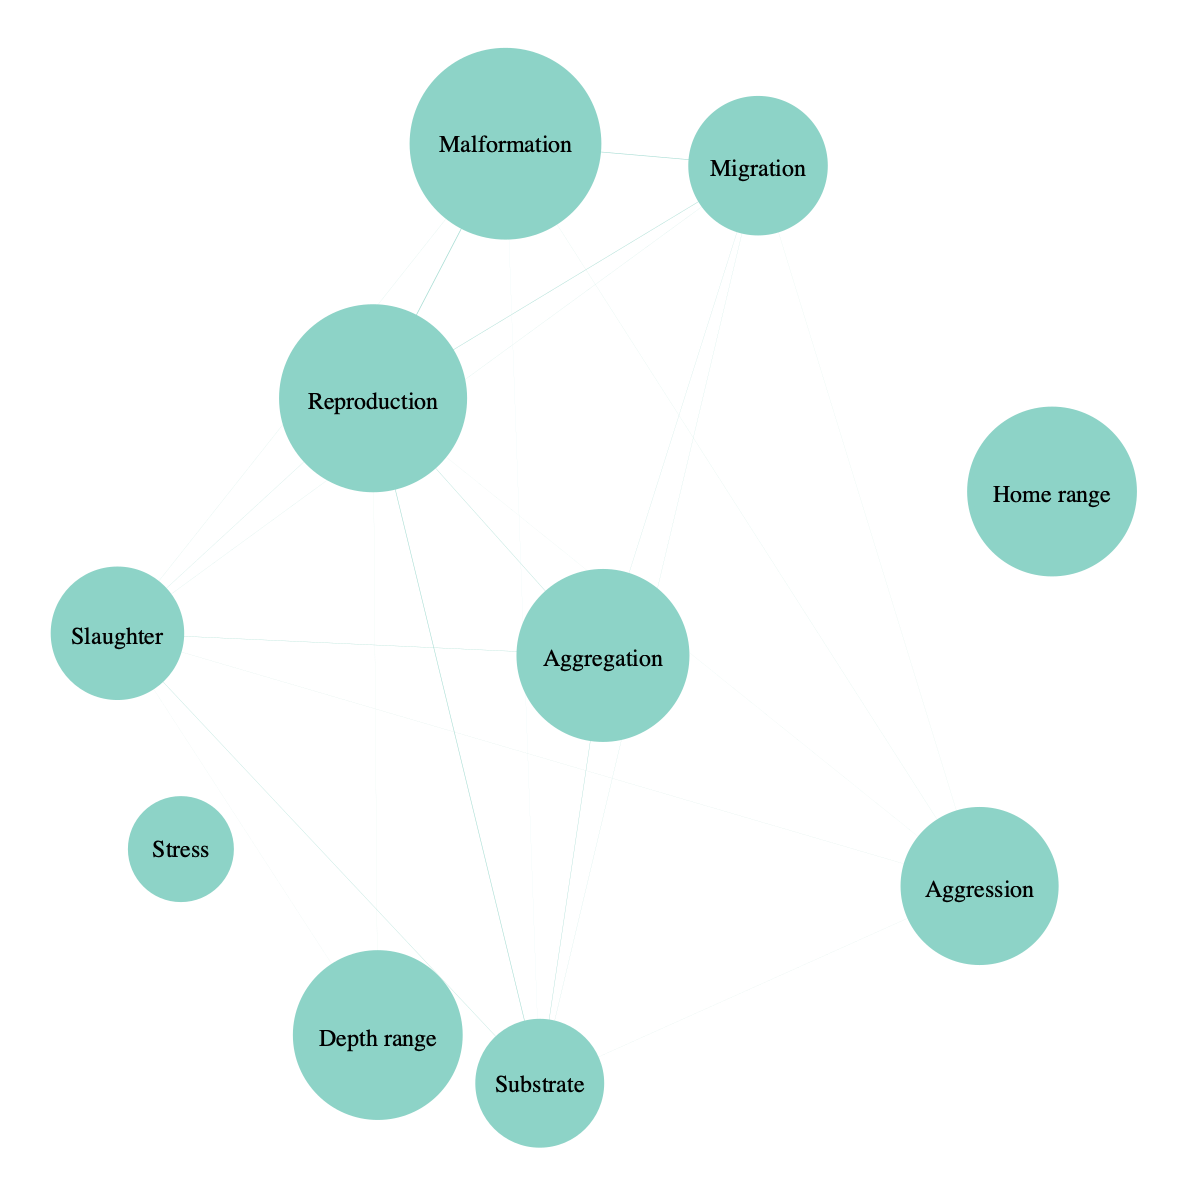

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17a8b9c60, at 0x17a897490>

In [26]:
# https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.BlockState
# https://graph-tool.skewed.de/static/doc/demos/inference/inference.html


# state = gt.minimize_blockmodel_dl(g, state=gt.PPBlockState)
state = gt.minimize_blockmodel_dl(g, state_args={'recs': [weight_shift], 'rec_types': ['real-normal']})
# state = gt.minimize_blockmodel_dl(g,
#                                   state_args={'recs': [weight_viz, sign], 'rec_types': ['real-normal', 'discrete-binomial']},)

entropy = state.entropy()
print(entropy)

print(f"Number of non-empty blocks: {state.get_Be()}")
print(f"Entropy: {state.entropy()}")

# visualise
export = False
if export:
    impath = join(wd, 'data', metric, measure, 'sbm_clusters.png')
else:
    impath = None


state.multiflip_mcmc_sweep(beta=np.inf, niter=100)

state.draw(pos=pos,
           vertex_size=50, vertex_text=name, vertex_font_size=12, vertex_shape="circle",
           vertex_pen_width=3,
           edge_pen_width=weight_viz, output=impath,
           fit_view_ink=True)

# iGraph methods

In [99]:
# Negative edges + multiplex
# Gives two different partitions
if False:
    # iGraph methods
    import igraph as ig
    import leidenalg as la

    optimiser = la.Optimiser()
    Gi = ig.Graph.from_networkx(G)

    G_pos = Gi.subgraph_edges(Gi.es.select(weight_gt = 0), delete_vertices=False)
    G_neg = Gi.subgraph_edges(Gi.es.select(weight_lt = 0), delete_vertices=False)
    G_neg.es['weight'] = [-w for w in G_neg.es['weight']]

    part_pos = la.ModularityVertexPartition(G_pos, weights='weight')
    part_neg = la.ModularityVertexPartition(G_neg, weights='weight')

    fig, axs = plt.subplots(2, 2)
    ig.plot(part_pos, target=axs[0, 0]);
    ig.plot(part_neg, target=axs[0, 1]);

    diff = optimiser.optimise_partition_multiplex([part_pos, part_neg], layer_weights=[1,-1]);
    print(diff)

    ig.plot(part_pos, target=axs[1, 0]);
    ig.plot(part_neg, target=axs[1, 1]);

In [30]:
if True:
    import igraph as ig
    import leidenalg as la

    optimiser = la.Optimiser()
    Gi = ig.Graph.from_networkx(G)
    
    partition = la.find_partition(Gi, la.CPMVertexPartition, resolution_parameter = 0.75)
    ig.plot(partition)

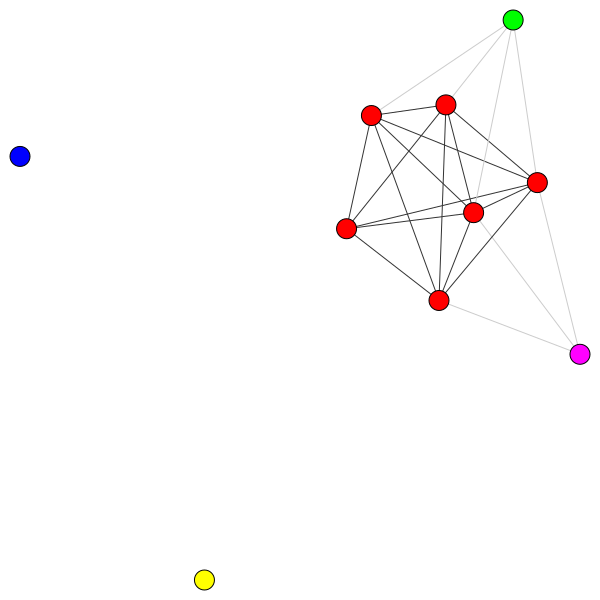

In [32]:
ig.plot(partition)